# Data Exploration for Citation-Integrity

This notebook presents data exploration for the **Citation-Integrity** dataset, incuding:
- Count and join sentences in abstracts
- Text statistics
    - Number of characters, words, and word length
    - Frequency of English stopwords and non-stopwords
- n-gram frequency
- Topic modeling
- Wordcloud
- Sentiment analyis
    - TextBlob
    - VADER
- Named entity recognition (NER)
- Parts of speech tagging (POS)
- Text complexity
- Key takeaways

This notebook was prepared by Jeffrey Dick on 2024-12-14.

- Most sections of this notebook between **Text statistics** and **Text complexity** were modified from [Exploratory Data Analysis for Natural Language Processing: A Complete Guide to Python Tools](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools) by [Shahul ES on neptune.ai](https://neptune.ai/blog/author/shahules).
- **NOTE:** The dataset analyzed in that post is news headlines; certain techniques (such as sentiment analysis) may not be as applicable to scientific abstracts.
- The code in the **Clean abstracts** abstracts section was modified from [What is Topic Modeling? An Introduction With Examples](https://www.datacamp.com/tutorial/what-is-topic-modeling).

Let's load the data and take a look at the first few abstracts.

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 100)

citint_corpus = pd.read_json('../data/citint/corpus.jsonl', lines=True)
citint_corpus.head()

,doc_id,title,abstract
0,66000,,[Accumulating evidence indicates that lncRNAs could play a critical role in regulation of cellul...
1,66001,,[We present evidence that loc285194 is a direct target for p53 and functions as a tumor suppress...
2,66002,,"[Finally, we demonstrate that loc285194 negatively regulates miR-211, which may in part account ..."
3,66003,,"[This miR-211-promoted cell growth was also seen in breast cancer MCF-7 cells (Figure 6B), sugge..."
4,66004,,"[Moreover, a muscle-specific lncRNA, linc-MD1, may act as a ‘sponges’ for miR-133 (16)., In this..."


## Count and join sentences in abstracts

In [2]:
from collections import Counter
Counter(citint_corpus['abstract'].apply(len))

Counter({5: 3052, 3: 4, 0: 3, 1: 2, 2: 1, 4: 1})

The vast majority of abstracts have 5 sentences.

Let's join the sentences in each abstract for further data exploration.
Also remove empty abstracts because they cause trouble for parts-of-speech (POS) tagging later on.

In [3]:
abstracts = citint_corpus['abstract'].str.join(' ')
abstracts = abstracts[abstracts != '']

## Text statistics

Plot the number of characters in each abstract.

<Axes: >

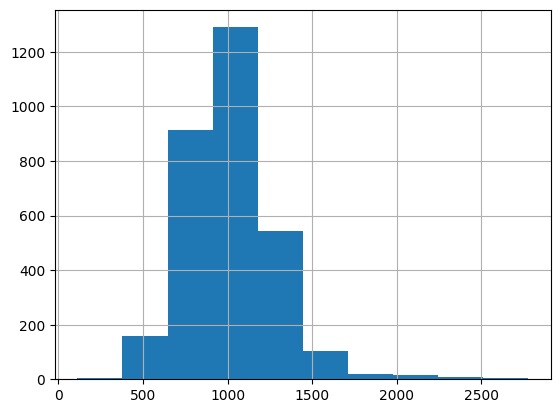

In [4]:
abstracts.str.len().hist()

Plot the number of words in each abstract.

<Axes: >

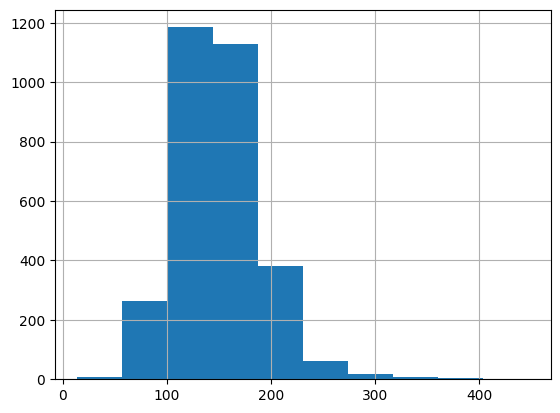

In [5]:
abstracts.str.split(). \
    map(lambda x: len(x)). \
    hist()

Plot the average word length in each abstract.

<Axes: >

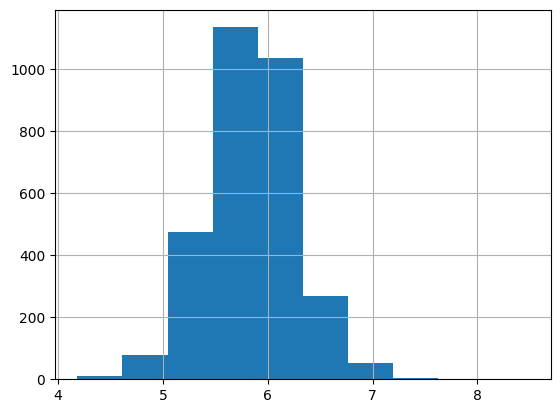

In [6]:
import numpy as np

abstracts.str.split(). \
   apply(lambda x: [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

Get English stopwords from NLTK.

In [7]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jedick/.local/lib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Create the corpus (a single list of words in all abstracts) and count the stopwords.

In [8]:
wordlists = abstracts.str.split().tolist()
corpus = [word for words in wordlists for word in words]

from collections import defaultdict
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

Plot the most frequent stopwords.

<BarContainer object of 10 artists>

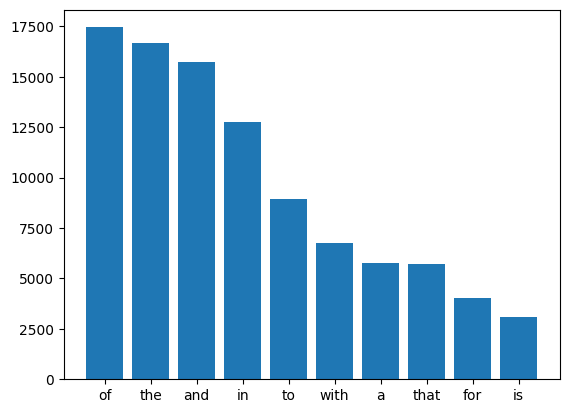

In [9]:
import matplotlib.pyplot as plt

top = sorted(dic.items(), key = lambda x:x[1], reverse = True)[:10] 
x, y = zip(*top)
plt.bar(x, y)

Plot the most frequent words that are not stopwords.

<Axes: >

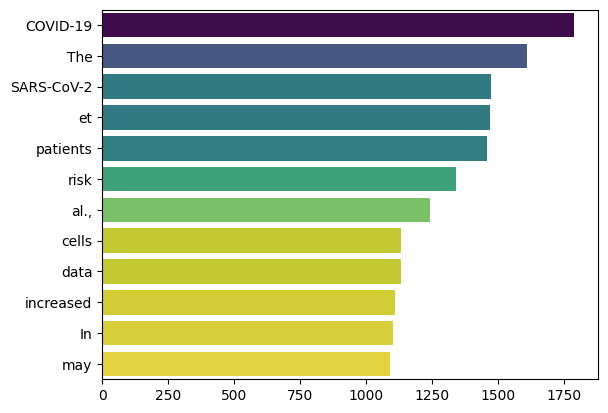

In [10]:
import seaborn as sns
from collections import  Counter

counter = Counter(corpus)
most = counter.most_common()

x, y = [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

# https://stackoverflow.com/questions/63573723/how-to-reverse-the-palette-of-a-seaborn-scatterplot
viridis_rev = plt.get_cmap('viridis').reversed()
sns.barplot(x=y, y=x, palette=viridis_rev, hue=y, legend=False)

It looks like capitalized words such as "The", "We", and "In" need to be lowercased to be recognized as stopwords.

## Clean abstracts

Here we lowercase and remove the stopwords as well as remove punctuation. Although a lemmatization step is provided, it is skipped in order to reveal actual n-grams.

In [11]:
# Code source: https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

import string
import nltk
nltk.download('stopwords')
#nltk.download('wordnet')

from nltk.corpus import stopwords
#from nltk.stem.wordnet import WordNetLemmatizer

# remove stopwords, punctuation, and normalize the corpus
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
#lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = "".join(ch for ch in stop_free if ch not in exclude)
    return punc_free
    #normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    #return normalized

clean_abstracts = [clean(doc) for doc in abstracts]

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jedick/.local/lib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## n-grams

Plot the most frequent bigrams in the abstracts.

<Axes: >

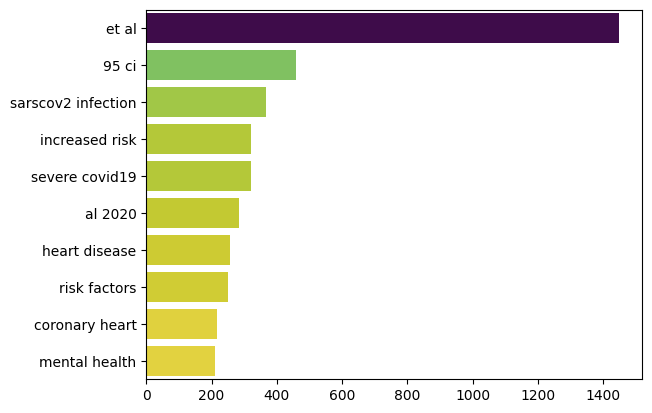

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:10]

top_n_bigrams = get_top_ngram(clean_abstracts, 2)[:10]
x, y = map(list, zip(*top_n_bigrams))
sns.barplot(x=y, y=x, palette=viridis_rev, hue=y, legend=False) 

Plot the most frequent trigrams.

<Axes: >

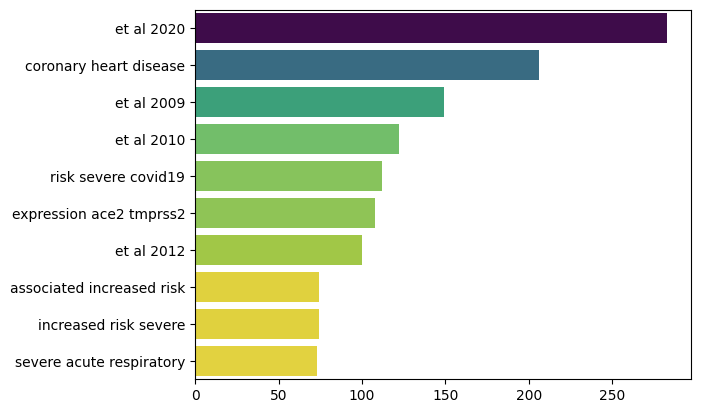

In [13]:
top_tri_grams = get_top_ngram(clean_abstracts, n=3)
x, y = map(list,zip(*top_tri_grams))
sns.barplot(x=y, y=x, palette=viridis_rev, hue=y, legend=False)

## Topic modeling

Topic modeling uses unsupervised learning techniques to extract the main topics in a collection of documents.

Latent Dirichlet Allocation (LDA) is a Bayesian method for topic modeling.
Each document is mapped to a list of topics and each topic is assigned to a different topic.
LDA uses bag of words (BOW), so word order is not important.

Preprocessing the data for LDA includes removing stopwords tokenization, removing stopwords, lemmatization, and bag of words.

- *removing stopwords*: this uses .lower() to remove capitalized stopwords
- *tokenization*: converting the text to a list of tokens (words or parts of words)
- *lemmatization*: grouping the inflected forms of a word to treat them as a single word
- *bag of words*: creates a dictionary with tokens as keys are tokens and frequency of occurrence as values

This code implements the first three steps using NLTK:

In [14]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

def preprocess_text(abstracts):
    corpus = []
    lem = WordNetLemmatizer()
    for abstracts in abstracts:
        words = [w for w in word_tokenize(abstracts) if (w not in stop)]
        words = [lem.lemmatize(w) for w in words if len(w)>2]
        corpus.append(words)
    return corpus

corpus = preprocess_text(abstracts)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/jedick/.local/lib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jedick/.local/lib/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The gensim package is used to create the bag of words.

In [15]:
import gensim

dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

Now we perform LDA:

In [16]:
lda_model = gensim.models.LdaMulticore(
    bow_corpus, num_topics=4, id2word=dic, passes=10, workers=2, random_state=42)
lda_model.show_topics()

[(0,
  '0.011*"risk" + 0.011*"COVID-19" + 0.010*"patient" + 0.010*"SARS-CoV-2" + 0.009*"disease" + 0.008*"study" + 0.007*"The" + 0.006*"data" + 0.006*"effect" + 0.006*"vaccine"'),
 (1,
  '0.012*"al." + 0.012*"cell" + 0.008*"SARS-CoV-2" + 0.007*"infection" + 0.007*"mitochondrial" + 0.007*"mouse" + 0.006*"COVID-19" + 0.005*"ferret" + 0.005*"model" + 0.005*"severe"'),
 (2,
  '0.013*"cell" + 0.008*"Fig" + 0.007*"mouse" + 0.007*"tumor" + 0.007*"cancer" + 0.006*"The" + 0.005*"gene" + 0.005*"protein" + 0.005*"expression" + 0.004*"data"'),
 (3,
  '0.012*"COVID-19" + 0.007*"patient" + 0.005*"HIV" + 0.005*"disease" + 0.005*"health" + 0.005*"among" + 0.005*"The" + 0.005*"care" + 0.005*"group" + 0.005*"study"')]

Let's make an interactive visualization of the LDA model.

- The areas of circles represents the relative importance of each topic.
- The distance between the circles represents inter-topic similarity.
- The histogram displays the 30 most relevant words in each topic.

In [17]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

/home/jedick/.local/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=4617) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/jedick/.local/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=4617) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/jedick/.local/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=4617) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/jedick/.local/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=4617) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/jedick/.local/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.160243 -0.087323       1        1  27.480012
0     -0.115595 -0.074188       2        1  25.272382
1      0.073824  0.127677       3        1  24.981785
3     -0.118472  0.033834       4        1  22.265822, topic_info=               Term         Freq        Total Category  logprob  loglift
357             al.  1179.000000  1179.000000  Default  30.0000  30.0000
13             cell  2107.000000  2107.000000  Default  29.0000  29.0000
2037       COVID-19  2037.000000  2037.000000  Default  28.0000  28.0000
337   mitochondrial   557.000000   557.000000  Default  27.0000  27.0000
64            tumor   555.000000   555.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
734      population   201.553039   606.535452   Topic4  -5.7651   0.4004
3437       diabetes   192.671041   560.904409   Topic4  -5.8102   0.4336
962       infection   214.002738  1353.210393   Topic4  -5.7052  -0.3421
960       increased   203.420190  1089.093057   Topic4  -5.7559  -0.1757
575            data   192.303215  1198.196962   Topic4  -5.8121  -0.3274

[337 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
16271      1  0.023330    .001
16271      4  0.956532    .001
11282      2  0.981369  0·0001
14560      2  0.987962   10−30
4705       4  0.976026   13–29
...      ...       ...     ...
903        4  0.397631    year
4723       1  0.013083   young
4723       2  0.013083   young
4723       3  0.039250   young
4723       4  0.941990   young

[751 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

## Wordcloud

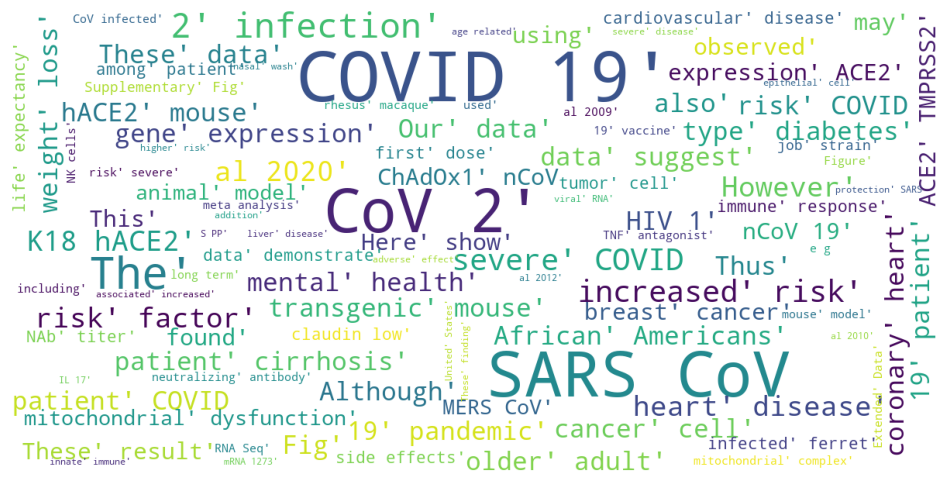

In [18]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color = 'white',
        stopwords = stopwords,
        max_words = 100,
        max_font_size = 30,
        scale = 3,
        random_state = 1)
    wordcloud = wordcloud.generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

## Sentiment analysis

Let's use two Python packages for performing sentiment analysis: [TextBlob](https://github.com/sloria/TextBlob) and [Vader Sentiment](https://github.com/cjhutto/vaderSentiment).

### TextBlob

We use the [sentiment property of the TextBlob library](https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis) to calculate polarity.
Polarity ranges from -1 (negative) to 1 (positive).

A second property calculated by the sentiment property is subjectivity.
This measure ranges from 0 (objective) to 1 (subjective).

<Axes: >

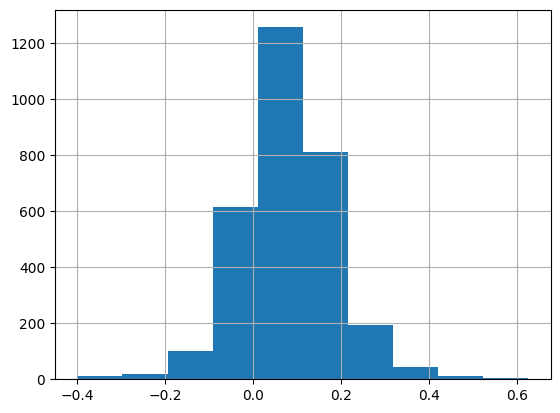

In [19]:
from textblob import TextBlob

polarity_score = abstracts.apply(lambda x: TextBlob(x).sentiment.polarity)
polarity_score.hist()

Let's use the polarity scores to classify the abstracts as Negative, Neutral, or Positive.

<BarContainer object of 3 artists>

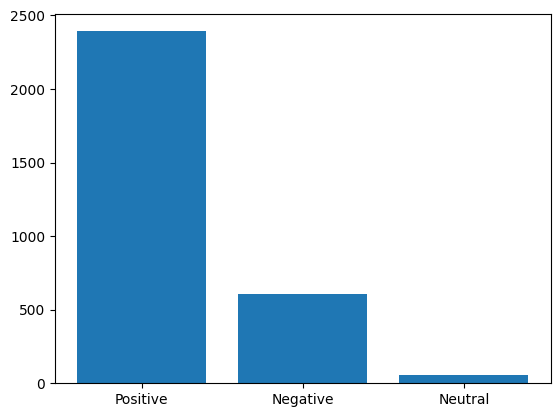

In [20]:
def sentiment(x):
    if x<0:
        return 'Negative'
    elif x==0:
        return 'Neutral'
    else:
        return 'Positive'

polarity = polarity_score. map(lambda x: sentiment(x))

plt.bar(polarity.value_counts().index, polarity.value_counts())

Print some of the positive and negative abstracts.

In [21]:
abstracts[polarity=='Positive'].head()

2     Finally, we demonstrate that loc285194 negatively regulates miR-211, which may in part account f...
10    For example, several groups have reported that the miR-34 family, including miR-34a, miR-34b and...
11    Accumulating evidence indicates that lncRNAs could play a critical role in regulation of cellula...
14    Recent advances in functional genomics have led to the discovery of a new type of regulatory gen...
30    It will be of interest to determine whether metformin treatment might provide a useful adjunct t...
Name: abstract, dtype: object

In [22]:
abstracts[polarity=='Negative'].head()

0    Accumulating evidence indicates that lncRNAs could play a critical role in regulation of cellula...
1    We present evidence that loc285194 is a direct target for p53 and functions as a tumor suppresso...
3    This miR-211-promoted cell growth was also seen in breast cancer MCF-7 cells (Figure 6B), sugges...
4    Moreover, a muscle-specific lncRNA, linc-MD1, may act as a ‘sponges’ for miR-133 (16). In this r...
5    Accordingly, lncRNAs may function as oncogenes and tumor suppressors in cancer just like protein...
Name: abstract, dtype: object

### VADER

VADER or Valence Aware Dictionary and Sentiment Reasoner analyzes sentiments in social media based on a lexicon and set of rules.

**NOTE:** The function returns proportional values for `neg`, `neu`, `pos` that sum to 1.
The [original post](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools) simply took the highest one of these values to make the classification.
However, the `compound` score is more sensitive as [mentioned on this page](https://digitalenvironment.org/natural-language-processing-vader-sentiment-analysis-with-nltk/).

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jedick/.local/lib/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<BarContainer object of 3 artists>

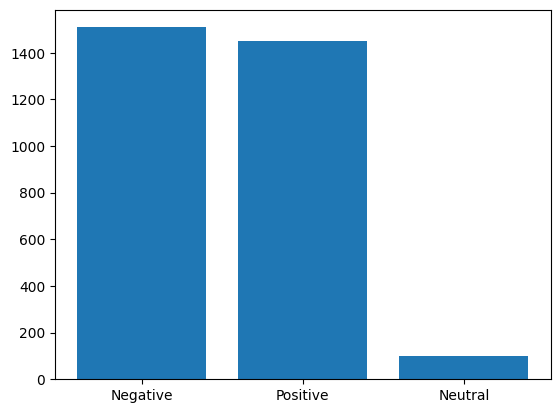

In [23]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

def get_vader_polarity(sent):
    ss = sid.polarity_scores(sent)
    # Use compound score to classify polarity
    # Recommended values from
    # https://digitalenvironment.org/natural-language-processing-vader-sentiment-analysis-with-nltk
    if ss['compound'] <= -0.05:
        return 'Negative'
    elif ss['compound'] >= 0.05:
        return 'Positive'
    else:
        return 'Neutral'

polarity = abstracts.map(lambda x: get_vader_polarity(x))
plt.bar(polarity.value_counts().index, polarity.value_counts())

## Named entity recognition

Let's perform NER using the `en_core_web_sm` model in spaCy.

```
python -m spacy download en_core_web_sm
```

After initializing the model with the nlp() function, we can visualize NER for a single abstract using the displacy module.

In [24]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm')

doc = nlp(abstracts[99])
displacy.render(doc, style = 'ent')

/home/jedick/.local/lib/python3.12/site-packages/spacy/displacy/__init__.py:69: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import HTML, display


This counts the types of entities in all the abstracts.

In [25]:
def ner(text):
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

ent = abstracts.apply(lambda x : ner(x))
ent = [x for sub in ent for x in sub]

counter = Counter(ent)
count = counter.most_common()

Plot the frequencies of named entities.

<Axes: >

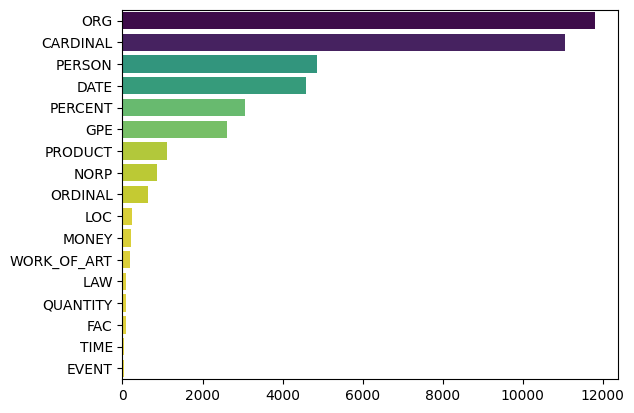

In [26]:
x, y = map(list, zip(*count))
sns.barplot(x=y, y=x, palette=viridis_rev, hue=y, legend=False)

Visualize the most common tokens for the ORG (organization) entity.

<Axes: >

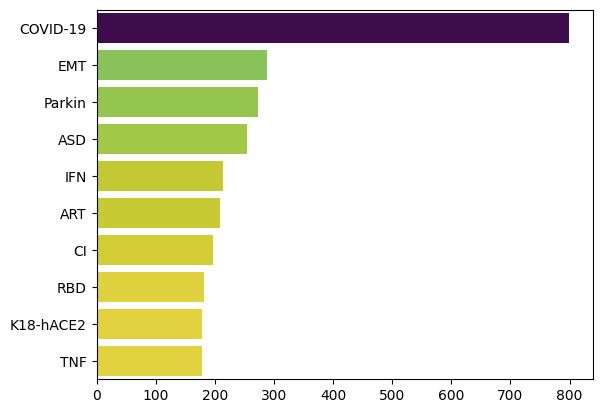

In [27]:
def ner(text, ent="ORG"):
    doc = nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

gpe = abstracts.apply(lambda x: ner(x))
gpe = [i for x in gpe for i in x]
counter = Counter(gpe)

x, y = map(list, zip(*counter.most_common(10)))
sns.barplot(x=y, y=x, palette=viridis_rev, hue=y, legend=False)

Visualize the most common tokens for the PERSON entity.

<Axes: >

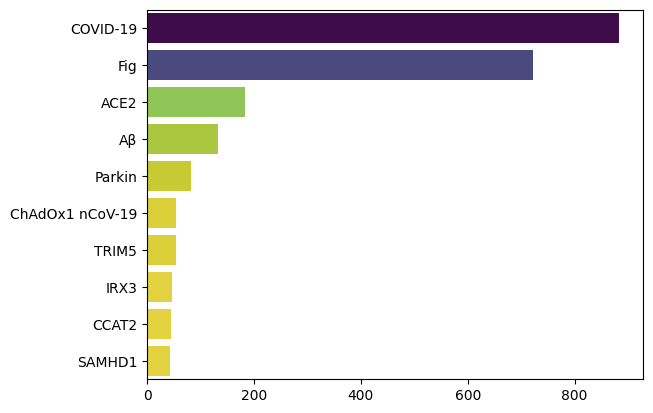

In [28]:
per = abstracts.apply(lambda x: ner(x, 'PERSON'))
per = [i for x in per for i in x]
counter = Counter(per)

x, y = map(list, zip(*counter.most_common(10)))
sns.barplot(x=y, y=x, palette=viridis_rev, hue=y, legend=False)

## Parts of speech

Let's use NLTK for parts-of-speech tagging.

<Axes: >

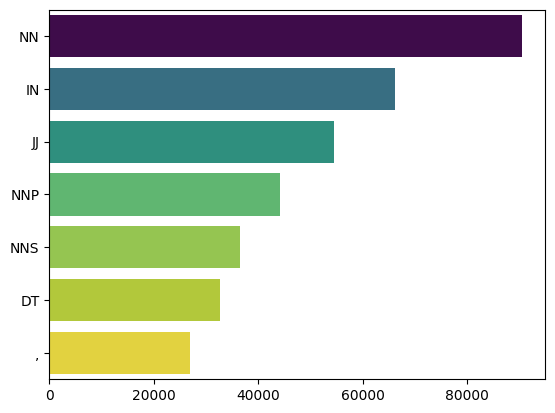

In [29]:
import nltk
from nltk.tokenize import word_tokenize

def pos(text):
    pos = nltk.pos_tag(word_tokenize(text))
    pos = list(map(list, zip(*pos)))[1]
    return pos

tags = abstracts.apply(lambda x: pos(x))
tags = [x for l in tags for x in l]
counter = Counter(tags)

x, y = list(map(list, zip(*counter.most_common(7))))
sns.barplot(x=y, y=x, palette=viridis_rev, hue=y, legend=False)

The three most frequent part of speech are noun (NN), preposition (IN), and adjective (JJ).

Visualize the most common singular nouns (NN) in the abstracts.

<Axes: >

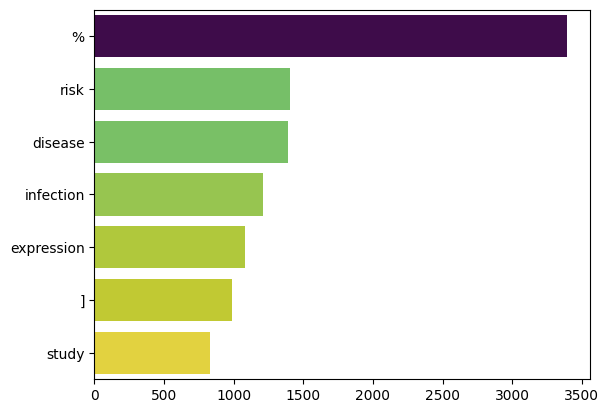

In [30]:
def get_nouns(text):
    noun = []
    pos = nltk.pos_tag(word_tokenize(text))
    for word, tag in pos:
        if tag=='NN':
            noun.append(word)
    return noun

words = abstracts.apply(lambda x: get_nouns(x))
words = [x for l in words for x in l]
counter = Counter(words)

x, y = list(map(list, zip(*counter.most_common(7))))
sns.barplot(x=y, y=x, palette=viridis_rev, hue=y, legend=False)

## Text complexity

**Flesch Reading Ease (FRE)** is one of many formulas for calculating readability of English text.
Material that is easier to read has higher FRE scores.
- FRE = 206.835 − 1.015 * (total words/total sentences) − 84.6 * (total syllables/total words)
- College level: 0-30
- High school level: 50-60
- Fourth grade level: 60+

Let’s visualize FRE scores calculated with the [Textstat](https://github.com/shivam5992/textstat) library.

/home/jedick/.local/lib/python3.12/site-packages/textstat/textstat.py:7: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/usr/lib/python3.12/site-packages/pkg_resources/__init__.py:3149: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/lib/python3.12/site-packages/pkg_resources/__init__.py:3149: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)


<Axes: >

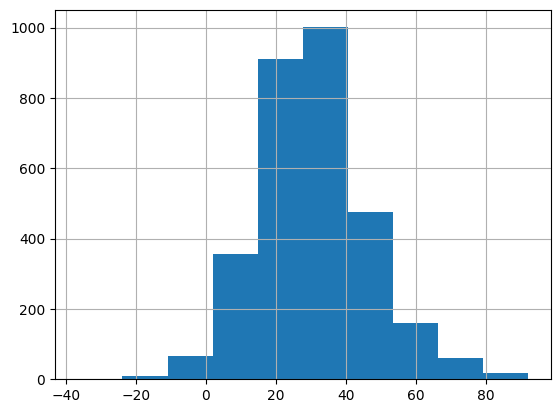

In [31]:
from textstat import flesch_reading_ease

fre = abstracts.apply(lambda x: flesch_reading_ease(x))
fre.hist()

Most of the readability scores are less than 50.
This means that an average high school student **would have trouble reading** the abstracts.
Some abstracts have scores less than 0, indicating low readability even for college students.

Let's print the hard-to-read abstracts: those with a readability score below -10.

In [32]:
abstracts[fre < -10]

192     Inclusion criteria Prospective cohort studies on the association between alcohol consumption and...
265     The primary outcome was initially a comparison of clinical status at day 15 on the eight-categor...
270     Scores on the ordinal scale are as follows: 1, not hospitalized, no limitations of activities; 2...
315     We propose that inhibition of mitochondrial fusion during Parkin-driven mitophagy contributes to...
713     Consistent with the hypothesis that developmental programs are reactivated during tumorigenesis ...
1568    BRCA2 focuses the assembly of RAD51 onto ssDNA and facilitates the RAD51-mediated displacement o...
1584    Although the effects of the environment on mitochondrial dysfunction are becoming increasingly r...
1604    Excitatory inputs to striatum arise from cortical and thalamic structures, while striatal inhibi...
1781    * The intensive glycaemia control intervention used in the Action to Control Cardiovascular Risk...
2142    ### Dietary L-carnit

Let's print the easier-to-read abstracts: those with a readability score above 80.

In [33]:
abstracts[fre > 80]

687     Separate logistic regression models were fit to examine the effect of weight loss on the odds of...
952     The RBD is the dominant target of neutralizing antibodies (Cao et al., 2020; Ju et al., 2020; Pi...
1078    In 2007–2010, 52.5% of people with diabetes achieved A1C <7.0% (<53 mmol/mol), 51.1% achieved BP...
1083    In 2007–2010, 52.5% of people with diabetes achieved A1C <7.0% (<53 mmol/mol), 51.1% achieved BP...
1084    In 2007–2010, 52.5% of people with diabetes achieved A1C <7.0% (<53 mmol/mol), 51.1% achieved BP...
1091    In 2007–2010, 52.5% of people with diabetes achieved A1C <7.0% (<53 mmol/mol), 51.1% achieved BP...
1774    The Kaplan–Meier estimates of mortality were 6.7% with remdesivir and 11.9% with placebo by day ...
2353    PA, physical activity. As individuals across the globe have become confined to their homes, dail...
2370    That is, deaths among patients in hospital at the study end point were 3.3 % or lower in patient...
2605    Time spent in sports

# Key takeaways
- Most of the abstracts have between 100 and 200 words.
- n-gram analysis would be improved by removing "et al." (perhaps this should be considered a stopword).
    - The frequent occurrence of "et al." serves as a reminder that the abstracts are actually sentences retrieved from the full text of articles.
- The main topics in these abstracts are related to cells, cancer, COVID-19, patients, infection, and disease.
- Our implementation of NER has trouble distinguishing medical terms, as COVID-19 appears in both the ORG and PERSON entities.
    - This is likely due to limitations of the [pretrained model used here](https://spacy.io/models/en/); see the [spaCy documentation for more information on NER](https://spacy.io/usage/linguistic-features#entity-linking).
- VADER classifies approximately equal numbers of abstracts as positive or negative, as opposed to mostly positive classifications by TextBlob.
    - Sentiment modeling is typically used for news and social media and may not provide great insight into scientific abstracts.
- Readability for most abstracts is at the college level.